# Environmental Data Science: An introductory lecture
The **objective** of this lecture is to introduce _environmental_ data science to students who are already learning applied data science (e.g., [Data 100](https://ds100.org)). But this isn't even _all_ of environmental data science &mdash; just the socioeconomic side and not the geophysics.

There are three key results of the lecture:
1. Briefly introduce `geopandas` as an extension to `pandas`, focusing on different expressions of the `geometry` attribute.
2. Illustrate and explain the value of spatial (vector!) data in environmental data science.
3. Describe and illustrate omitted variable bias and make a case for the importance of the issue in environmental data analysis.

## Spatial data

### An introduction to `geopandas`

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
## Create a dataframe of random latitude-longitude pairs
x = np.random.uniform(-180, 180, 1000)
y = np.random.uniform(-90, 90, 1000)

df = pd.DataFrame(
    {
        "longitude": x,
        "latitude" : y
    }
)

df.head()

,longitude,latitude
0,147.947554,-80.877776
1,-138.466524,-53.432630
2,-80.772774,0.537641
3,-132.794273,29.360498
4,-105.880955,26.820838


In [3]:
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

gdf

,longitude,latitude,geometry
0,147.947554,-80.877776,POINT (147.94755 -80.87778)
1,-138.466524,-53.432630,POINT (-138.46652 -53.43263)
2,-80.772774,0.537641,POINT (-80.77277 0.53764)
3,-132.794273,29.360498,POINT (-132.79427 29.36050)
4,-105.880955,26.820838,POINT (-105.88096 26.82084)
...,...,...,...
995,-4.289930,4.223718,POINT (-4.28993 4.22372)
996,-70.374702,-31.315994,POINT (-70.37470 -31.31599)
997,-171.053064,3.708869,POINT (-171.05306 3.70887)
998,11.562465,54.312851,POINT (11.56246 54.31285)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

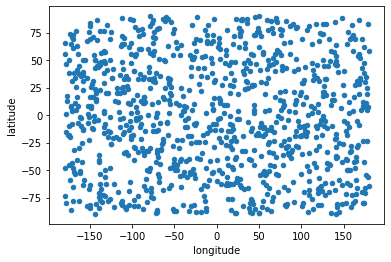

In [4]:
## Built-in plotting does not include CRS or Projections, but points are points
## NOTE: I won't go into the finer points of projections or coordinate reference systems 
## because I want you to like me. And you won't like me if I start talking about that.
df.plot.scatter(x="longitude", y="latitude")

<AxesSubplot:>

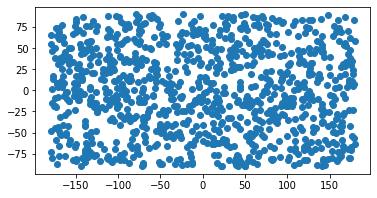

In [5]:
## The coordinates *mean* something. No need to label the axes as lat-lon.
gdf.plot()

In [6]:
## Polygon geometry rather than point geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

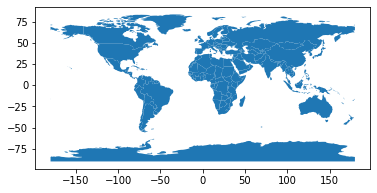

In [7]:
world.plot()

<AxesSubplot:>

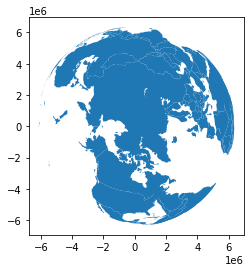

In [8]:
## Easy to reconfigure 
world.to_crs("EPSG:7789").plot()

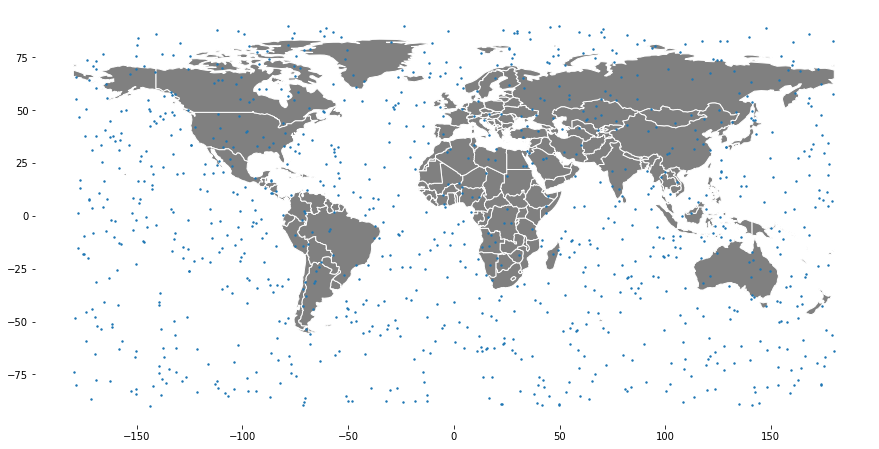

In [9]:
fig, geo_ax = plt.subplots(figsize=(15, 10))

world[world.name != "Antarctica"].plot(
    ax=geo_ax,
    color="grey",
    edgecolor="white"
)

gdf.plot(
    ax=geo_ax,
    markersize=2
)

plt.box(None)

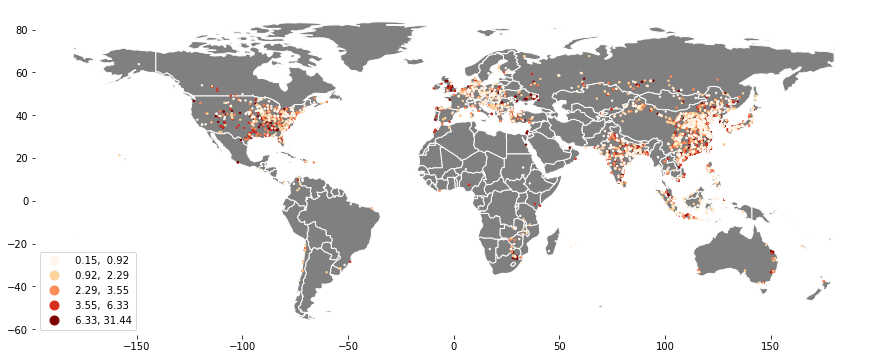

In [10]:
# Coal fired powerplants from https://www.carbonbrief.org/mapped-worlds-coal-power-plants
# Annual carbon reported in MtCO2
power_gdf = gpd.read_file("https://global-coal-map-2020.s3.eu-west-2.amazonaws.com/data/coal2020.geojson")

fig, geo_ax = plt.subplots(figsize=(15, 10))

world[world.name != "Antarctica"].plot(
    ax=geo_ax,
    color="grey",
    edgecolor="white"
)

power_gdf.plot(
    ax=geo_ax,
    markersize=2,
    cmap="OrRd",
    column="annualCarbon",
    scheme='QUANTILES',
    legend=True
)

plt.box(None)

### A natural experiment from spatial data

In [11]:
## US State Map
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")

## Farmers markets
farmers_mkts = pd.read_csv("https://raw.githubusercontent.com/danhammer/envirods/main/data/farmers-mkts.csv")
farmers_mkts = gpd.GeoDataFrame(
    farmers_mkts, 
    geometry=gpd.points_from_xy(farmers_mkts.x, farmers_mkts.y)
)

In [12]:
## Limit to just the Four Corners states
states = ["New Mexico", "Arizona", "Utah", "Colorado"]

state_gdf = usa[usa.NAME.isin(states)]
mkt_gdf = farmers_mkts[farmers_mkts.State.isin(states)]

<AxesSubplot:>

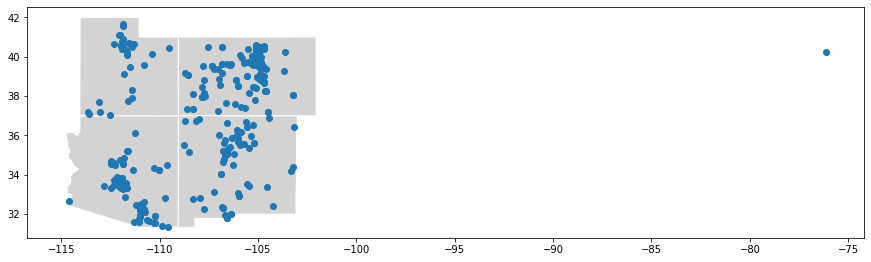

In [13]:
fig, ax = plt.subplots(figsize=(15,10))

state_gdf.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white"
)

mkt_gdf.plot(ax=ax)

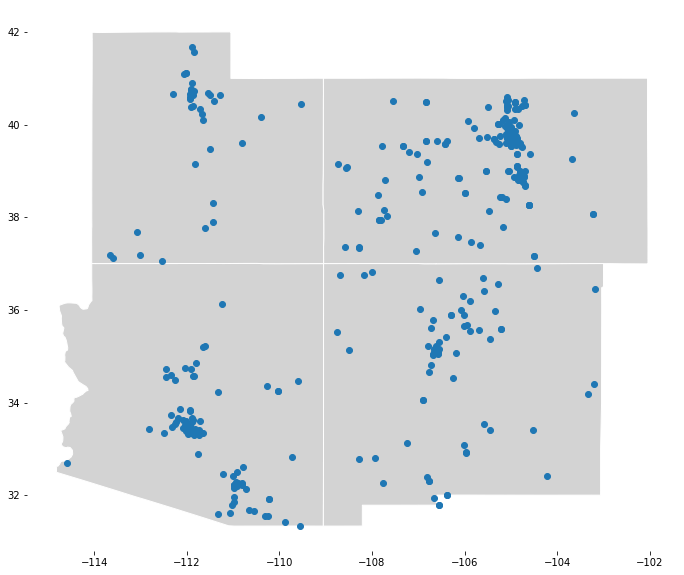

In [14]:
## Remove outlier. Not my table. 
mkt_gdf = mkt_gdf[mkt_gdf.x < -100]

fig, ax = plt.subplots(figsize=(15,10))

state_gdf.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white"
)

mkt_gdf.plot(ax=ax)
plt.box(None)

In [15]:
mkt_gdf.head()

,FMID,State,Zip,Schedule,x,y,Location,Credit,WIC,WICcash,...,Meat,Nursery,Nuts,Plants,Poultry,Prepared,Soap,Trees,Wine,geometry
22,22004647,Colorado,NaN,NaN,-105.073000,40.395400,NaN,N,N,N,...,N,N,N,N,N,N,N,N,N,POINT (-105.07300 40.39540)
51,1002771,New Mexico,NaN,June - October Saturday 7:00 AM to 12:00 PM,-106.565838,35.103988,Other,Y,Y,N,...,N,N,N,N,N,N,N,N,N,POINT (-106.56584 35.10399)
52,1002771,New Mexico,NaN,June - October Tuesday 7:00 AM to 12:00 PM,-106.633172,35.082375,Healthcare Institution,Y,Y,N,...,N,N,N,N,N,N,N,N,N,POINT (-106.63317 35.08237)
53,1000998,Colorado,80903,June - October Monday 10:00 AM to 3:00 PM,-104.823038,38.838084,Local government building grounds,Y,N,N,...,Y,N,N,Y,N,Y,Y,N,N,POINT (-104.82304 38.83808)
75,22002651,Arizona,85233,NaN,-111.726000,33.321900,NaN,N,N,N,...,N,N,N,N,N,N,N,N,N,POINT (-111.72600 33.32190)


In [16]:
## Limit the dataframe and encode the attributes for the presence of features of 
## the markets.
attributes = [
    'Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP', 'Bakedgoods', 'Cheese', 'Crafts',
    'Flowers', 'Eggs', 'Seafood', 'Herbs', 'Vegetables', 'Honey', 'Jams',
    'Maple', 'Meat', 'Nursery', 'Nuts', 'Plants', 'Poultry', 'Prepared',
    'Soap', 'Trees', 'Wine'
]

X = mkt_gdf[attributes]
X = (X == "Y").astype(int)
X

,Credit,WIC,WICcash,SFMNP,SNAP,Bakedgoods,Cheese,Crafts,Flowers,Eggs,...,Maple,Meat,Nursery,Nuts,Plants,Poultry,Prepared,Soap,Trees,Wine
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,1,0,0,0,1,1,1,1,1,1,...,0,1,0,0,1,0,1,1,0,0
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7626,0,0,0,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
7726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7779,0,0,0,0,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
7780,0,0,0,0,1,1,1,1,0,1,...,0,1,0,1,1,1,1,1,0,0


You will learn more about clustering and unsupervised learning later. For now, just note that this is a particular method to organize the data into `n` clusters, based on the attribute matrix. 

In [17]:
from sklearn.cluster import AgglomerativeClustering

# the distance between points is given by `euclidean` while the clusters 
# are defined by minimizing variance using the Ward method.
cluster = AgglomerativeClustering(
    n_clusters=5, 
    affinity='euclidean', 
    linkage='ward'
)

# assign a new column based on the label and print the values in the new column
label = cluster.fit_predict(X.values)

# what are the different labels?
set(label)

{0, 1, 2, 3, 4}

<AxesSubplot:>

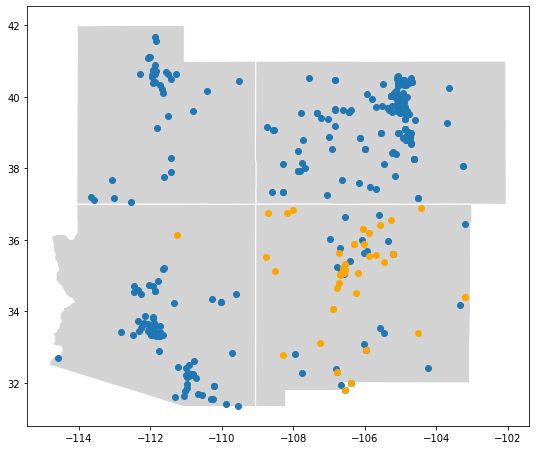

In [18]:
# plot the labels, incrementally, on a map to figure out if there is a geographic
# pattern associated with it.
fig, ax = plt.subplots(figsize=(9,9))

state_gdf.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white"
)

# cycle through the labels,
# note that the label "1" seems to reflect farmers' markets in New Mexico
mkt_gdf[label != 1].plot(
    ax=ax
)

# plot the New Mexico farmers' markets
mkt_gdf[label == 1].plot(
    ax=ax,
    color="orange"
)

## Omitted variable bias
Suppose that you want to understand the impact of _nature_ on home price.  How do you even value nature?  I know I like to hear the birds when I wake up. I know I like to see trees instead of a desolate, concrete landscape. But how do you measure it? 

There are a few common themes of environmental data science, including: 
1. There are many things that are unobserved or even unobservable &mdash; and definitely not measured.
2. Everything is connected.

Those two themes are basically the recipe for omitted variable bias in regression analysis. Consider a made-up example that illustrates the relationship between home price, distance to city center, and _greenness_ (a sort of short-hand for nature). Let

\begin{align}
price_i& =\beta_0 + \beta_1 distance_i + \beta_2 greenness_i + \epsilon_i\\
distance_i& =\alpha_0 + \alpha_1 greenness_i + \gamma_i
\end{align}

There are two conditions for omitted varaible bias: (1) the omitted variable must be a determinant of the dependent variable (i.e., $\beta_2 \neq 0$); and (2) the omitted variable must be correlated with an independent variable specified in the regression.  We can create a scenario where both of these conditions are met by playing an omnipotent creator and specifying the true, natural coefficients. The bottom line is that "_Everything is connected._"

In this scenario, _greenness_ is the omitted variable.  It's slightly confusing, since this omission will manifest in bias for the coefficient or impact of _distance to city center_ on home price.  But the bias is introduced all the same.  (We can omit _distance_, but that ends up being a little more conceptually confusing, even though it's the identical statistical issue.)

In [19]:
# import this library for a simple linear regression
from scipy import stats

In [23]:
# Create a dummy dataset
N = 10000

beta0 = 200000
beta1 = 500
beta2 = -1000

alpha0 = 50
alpha1 = 0.5

_df = pd.DataFrame(
    data = {
        "greenness": np.random.uniform(0, 100, N),
        "epsilon": np.random.normal(0, 7000, N),
        "gamma": np.random.normal(0, 10, N)
    }
)

_df["distance"] = alpha0 + alpha1*_df.greenness + _df.gamma
_df["homeprice"] = beta0 + beta1*_df.greenness + beta2*_df.distance + _df.epsilon


True impact: -1000
Estimated impact: -318.78357348211284


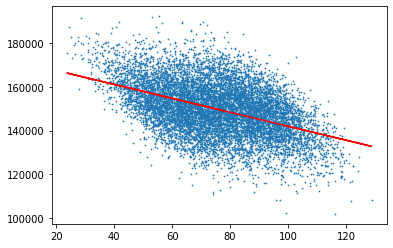

In [24]:
plt.scatter(
    _df.distance,
    _df.homeprice,
    s=0.5
)

m, b, _, _, _ = stats.linregress(_df.distance, _df.homeprice)

plt.plot(
    _df.distance,
    b + m * _df.distance,
    color="red"
)

print(f"True impact: {beta2}")
print(f"Estimated impact: {m}")

True impact: -1000
Estimated impact: -318.78357348211284


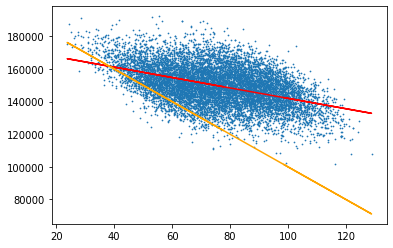

In [26]:
## Add the true relationship between distance and home price in orange
## We know TRUTH because we set it, as the all-knowing creator
## Shows that if something isn't measured, it's not valued
plt.scatter(
    _df.distance,
    _df.homeprice,
    s=0.5
)

plt.plot(
    _df.distance,
    b + m * _df.distance,
    color="red"
)

plt.plot(
    _df.distance,
    beta0 + beta2*_df.distance,
    color="orange"
)

print(f"True impact: {beta2}")
print(f"Estimated impact: {m}")